In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm
from datetime import datetime

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [3]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [5]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [6]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


In [13]:
train_data=train_data[train_data["TurbID"].isin(np.arange(1,25))]
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
691195,24,200,23:10,6.01,-4.92,392.54,13.18,209.81,-1.78,-1.78,-1.78,-205.55,559.92
691196,24,200,23:20,3.99,-4.50,392.54,12.98,202.34,-1.99,-1.99,-1.99,-109.25,249.27
691197,24,200,23:30,3.60,-1.83,392.54,12.80,192.61,-1.99,-1.99,-1.99,-109.05,204.64
691198,24,200,23:40,3.59,1.38,392.54,12.51,191.72,-1.99,-1.99,-1.99,-104.01,205.26


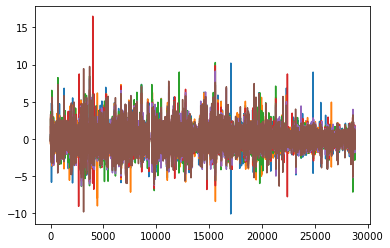

In [24]:
for i in range(1,7):
    plt.plot(np.arange(28800),train_data[train_data["TurbID"]==i]['Wspd'].diff())

In [72]:
# Y value 추가
train_data['Wspd_y']=train_data['Wspd']

# 위치 변수 추가.

# 데이터셋

In [73]:
train_data['Wspd']=train_data['Wspd'].shift(+1).fillna(method="bfill")

In [74]:
# X 값들 수정해주기
#for dat in X_data:
#    dat[:,1]=np.log1p(dat[:,1])



In [75]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 175): # 1~174까지 train set으로 쓰는것. 
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


def make_valid_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(175, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


In [76]:
#train_data = train_data[train_data['TurbID']==21]

In [77]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
nor = MinMaxScaler()# 
y_nor = MinMaxScaler()

train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]] = nor.fit_transform(train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]])
train_data[["Wspd_y"]] = y_nor.fit_transform(train_data[["Wspd_y"]])

#["TurbID", "Day","Patv","Etmp","Ndir"]

In [78]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,00:00,0.234690,0.571311,30.73,0.527252,25.92,0.100018,1.00,1.00,0.562729,494.66,0.234690
1,1,1,00:10,0.234690,0.571311,30.73,0.527252,25.92,0.100018,1.00,1.00,0.562729,494.66,0.234690
2,1,1,00:20,0.234690,0.571653,30.60,0.526968,20.91,0.100018,1.00,1.00,0.562738,509.76,0.238494
3,1,1,00:30,0.238494,0.571927,30.52,0.526784,20.91,0.100018,1.00,1.00,0.562720,542.53,0.244199
4,1,1,00:40,0.244199,0.572232,30.49,0.526549,20.91,0.100018,1.00,1.00,0.562747,509.36,0.237733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,0.195131,0.572948,9.04,0.474689,174.39,0.091017,0.01,0.01,0.465555,308.65,0.184861
3859196,134,200,23:20,0.184861,0.571309,8.79,0.474572,179.76,0.091017,0.01,0.01,0.478607,221.60,0.169646
3859197,134,200,23:30,0.169646,0.572049,8.74,0.474388,172.35,0.091017,0.01,0.01,0.462790,220.60,0.160898
3859198,134,200,23:40,0.160898,0.570909,8.64,0.474187,172.35,0.091017,0.01,0.01,0.465636,222.15,0.165843


In [79]:
y_nor.scale_

array([0.03803728])

In [80]:
#실험
#nor.min_=nor.min_[0]
#nor.scale_=nor.scale_[0]

In [81]:
y_nor.inverse_transform(train_data[["Wspd_y"]])

array([[6.17],
       [6.17],
       [6.27],
       ...,
       [4.23],
       [4.36],
       [4.79]])

In [82]:
tms_list = list(pd.unique(train_data["Tmstamp"]))
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


X_data, Y_data = make_train_data(train_data)
valid_X_data, valid_Y_data = make_valid_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:03<00:00, 40.30it/s]


In [83]:
len(X_data)# 5일학습 기준 윈도우는 터빈당 194개. 194개 마다 hidden state 초기화 필요,

23316

In [84]:
len(valid_X_data)

2680

In [85]:
pd.DataFrame(X_data[193])

,0,1,2,3,4,5
0,0.0,0.406238,0.566243,0.508219,0.912530,0.562684
1,0.0,0.413085,0.566318,0.508035,0.912530,0.562684
2,0.0,0.408901,0.566196,0.507985,0.912530,0.562684
3,0.0,0.412324,0.566265,0.507684,0.912530,0.562684
4,0.0,0.408901,0.566422,0.507767,0.912530,0.562684
...,...,...,...,...,...,...
715,23.0,0.333207,0.573673,0.504486,0.091198,0.654678
716,23.0,0.349943,0.571966,0.504587,0.091107,0.645319
717,23.0,0.324838,0.571627,0.504670,0.091107,0.629393
718,23.0,0.303157,0.572750,0.503750,0.091198,0.601749


In [17]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

In [14]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
fourier_features(train_data['Tmstamp'], 24, 1)

train_data.drop(['Tmstamp'],axis=1,inplace=True)

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


 database. History logging moved to new session 1439


TypeError: strptime() argument 1 must be str, not numpy.int64

In [19]:
#train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1 )
# 0.1 validation :117~121 , ...순서가 잘못됨.
# 0.05 validation :

In [86]:
train_x  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
train_y= np.array(Y_data)


valid_x  = np.array(valid_X_data).reshape(-1, valid_X_data[0].shape[0], valid_X_data[0].shape[1])
#train_x = np.array(X_data)
valid_y = np.array(valid_Y_data)

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

# 한터빈당 20개의 배치를 가진다.

(23316, 720, 6) (23316, 288)
(2680, 720, 6) (2680, 288)


In [87]:
pd.DataFrame(valid_x[19])

,0,1,2,3,4,5
0,0.0,0.166984,0.572567,0.508822,0.099927,0.562684
1,0.0,0.184100,0.571525,0.508922,0.099927,0.562711
2,0.0,0.179536,0.571602,0.508906,0.099927,0.562711
3,0.0,0.181057,0.571802,0.508136,0.099927,0.562702
4,0.0,0.179536,0.571066,0.508956,0.099927,0.562702
...,...,...,...,...,...,...
715,23.0,0.586154,0.572206,0.506947,0.101473,0.562783
716,23.0,0.590339,0.572063,0.506662,0.101473,0.562756
717,23.0,0.602130,0.572229,0.506545,0.101564,0.562738
718,23.0,0.626854,0.572893,0.506495,0.101564,0.562756


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

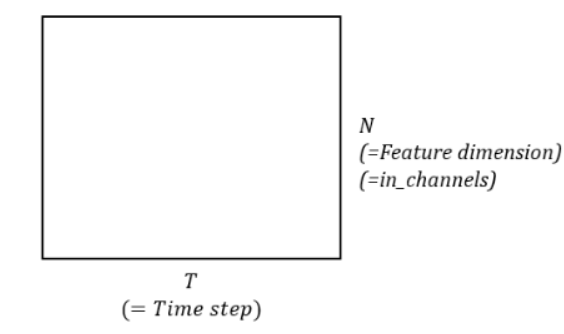

# 데이터 로더

In [88]:
EPOCHS = 50
BATCH_SIZE = 128
lr = 1e-3

In [89]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [90]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [91]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 720, 6]) type: torch.FloatTensor
Y_train :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


In [92]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([128, 720, 6]) type: torch.FloatTensor
Y_valid :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [105]:
lstm = nn.LSTM(input_size=12, hidden_size=256, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [106]:
lstm(X_valid)[0][-1].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [107]:
lstm(X_valid)[1][0]

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [29]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 256])

In [70]:
c1 = nn.Conv1d(in_channels=720, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
c2 = nn.Conv1d(in_channels=488, out_channels=256, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
pool1 = nn.MaxPool1d(kernel_size=3,stride=1)


o1 = c1(X_valid)
print(o1.size())
#o2 = pool1(o1)
#print(o1.size())

o2 = c2(o1)
print(o2.size())
o3 = pool1(o2)
print(o3.size())
#c1(X_valid).size()

torch.Size([128, 488, 6])
torch.Size([128, 256, 6])
torch.Size([128, 256, 4])


In [93]:
lstm_hidden_size=512
lstm_input_size = 6# after cnn

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True,
                           bidirectional=True)
        #self.c1 = nn.Conv1d(in_channels=720, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        #self.c2 = nn.Conv1d(in_channels=488, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        #self.c3 = nn.Conv1d(in_channels=488, out_channels=288, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size*2,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
    

        
    def forward(self, x):
        #x = self.c1(x)
        #x = self.c2(x)
        #x = self.c3(x)
        #x = self.pool1(x)
        
        output,_ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [94]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        
        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss
    


In [95]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [96]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_baseline.pt

[EPOCH:1]	 Train Loss:4.7471	 Train MAE:22.9309  | 	Valid Loss:0.4480 	Valid MAE: 2.3466

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 0.4480 


[EPOCH:2]	 Train Loss:4.0080	 Train MAE:20.8148  | 	Valid Loss:0.4265 	Valid MAE: 2.2596

-- SAVE Checkpoint --
Valid loss : 0.4480 -> 0.4265 


[EPOCH:3]	 Train Loss:3.8339	 Train MAE:20.3538  | 	Valid Loss:0.4170 	Valid MAE: 2.2423

-- SAVE Checkpoint --
Valid loss : 0.4265 -> 0.4170 


[EPOCH:4]	 Train Loss:3.7116	 Train MAE:19.9964  | 	Valid Loss:0.4066 	Valid MAE: 2.2235

-- SAVE Checkpoint --
Valid loss : 0.4170 -> 0.4066 


[EPOCH:5]	 Train Loss:3.5197	 Train MAE:19.4705  | 	Valid Loss:0.4005 	Valid MAE: 2.2193

-- SAVE Checkpoint --
Valid loss : 0.4066 -> 0.4005 


[EPOCH:6]	 Train Loss:3.2054	 Train MAE:18.4846  | 	Valid Loss:0.3776 	Valid MAE: 2.1771

-- SAVE Checkpoint --
Valid loss : 0.4005 -> 0.3776 


[EPOCH:7]	 Train Loss:2.6617	 Train MAE:16.8711  | 	Valid Loss:0.4110 	Valid MAE: 2.

In [34]:
ddddd

NameError: name 'ddddd' is not defined

# validation 확인

In [97]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.3776 / Valid MAE : 2.1771 



In [31]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

# lstm baseline : Valid loss : 0.3510 / Valid MAE : 2.1029 

Valid loss : 0.3510 / Valid MAE : 2.1029 



# TEST

In [98]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(100, 105)]

test_data = train_data[train_data["Day"].isin(test_data_list)]
test_data = test_data[test_data['TurbID']==21]
#전처리했다면, X_data로 불러와야함.


test_data = test_data.drop(["TurbID","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [99]:
test_data

array([[[ 0.        ,  0.27424876,  0.57254583,  0.53275972,
          0.09101655,  0.57164604],
        [ 0.        ,  0.28413846,  0.5722589 ,  0.53306103,
          0.09101655,  0.57094345],
        [ 0.        ,  0.22251807,  0.57231553,  0.53371388,
          0.09101655,  0.55193752],
        ...,
        [23.        ,  0.09319133,  0.5718889 ,  0.52705146,
          0.09101655,  0.56248536],
        [23.        ,  0.07835679,  0.57158121,  0.53024875,
          0.09101655,  0.56381848],
        [23.        ,  0.064283  ,  0.57312913,  0.5327095 ,
          0.28877978,  0.56278261]]])

In [100]:
test_data.shape

(1, 720, 6)

In [101]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [102]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [103]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (lstm): LSTM(6, 512, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [104]:
model.lstm

LSTM(6, 512, batch_first=True, bidirectional=True)

In [105]:
preds = predict(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


In [106]:
y_nor.scale_

array([0.03803728])

In [107]:
preds = y_nor.inverse_transform(preds)
preds = preds.reshape(-1)

In [108]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [109]:
for i in range(1,135):
    sample_submission.loc[sample_submission["TurbID"]==i,"Wspd"] = preds

In [110]:

sample_submission.to_csv("./submit.csv", index = False)

In [111]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,1.927636,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,1.945561,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,2.167133,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,2.474319,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,2.523769,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,5.221709,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,5.382477,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,5.126359,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,5.163498,0,0,0,0,0,0,0,0,9999


(0.0, 20.0)

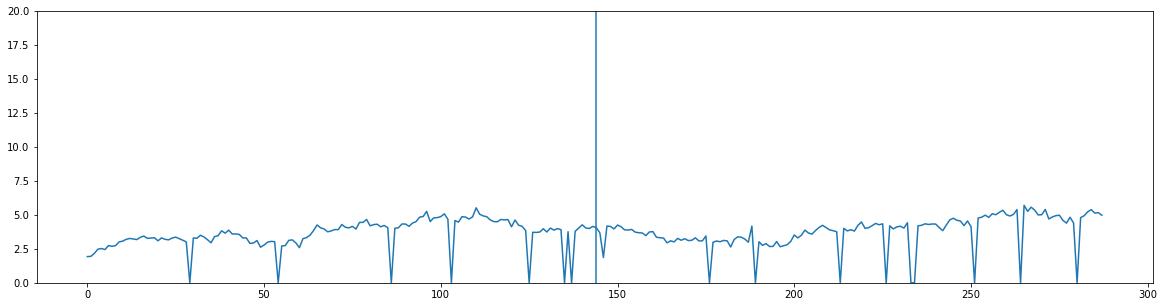

In [112]:
plt.figure(figsize=(20, 5))
plt.plot(sample_submission.loc[sample_submission["TurbID"]==1,"Wspd"])
plt.vlines(144,0,20)
plt.ylim([0,20])

(0.0, 1.0)

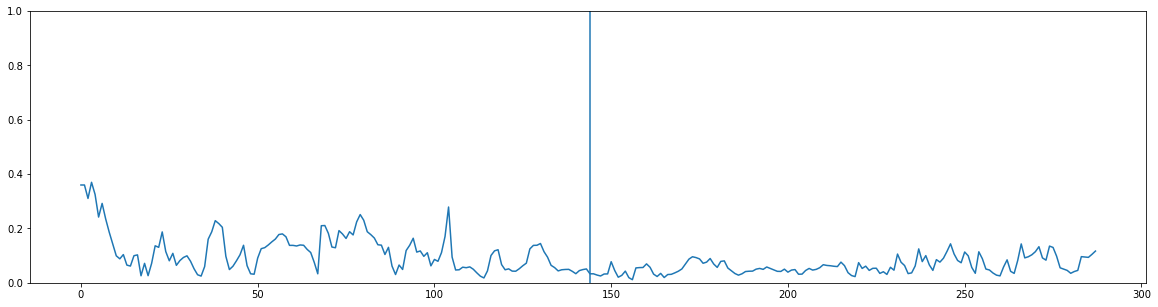

In [113]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(0,288),train_data.loc[ ((train_data["Day"]==105)|(train_data["Day"]==106
                                                                    )) &(train_data["TurbID"]==1) ,"Wspd"])
plt.vlines(144,0,1)
plt.ylim([0,1])